# 🛩️ Aircraft Engine Failure Detection - Data Exploration

## NASA C-MAPSS Turbofan Engine Degradation Dataset

This notebook explores the **Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation** dataset.

### Objective
Predict the **Remaining Useful Life (RUL)** - the number of operational cycles an aircraft engine will continue to operate before failure.

### Dataset Overview
| Dataset | Train | Test | Operating Conditions | Fault Modes |
|---------|-------|------|---------------------|-------------|
| FD001 | 100 | 100 | 1 (Sea Level) | 1 (HPC Degradation) |
| FD002 | 260 | 259 | 6 | 1 (HPC Degradation) |
| FD003 | 100 | 100 | 1 (Sea Level) | 2 (HPC + Fan Degradation) |
| FD004 | 248 | 249 | 6 | 2 (HPC + Fan Degradation) |

### Data Columns
- **Column 1:** Engine unit number
- **Column 2:** Time (operational cycles)
- **Columns 3-5:** Operational settings (altitude, Mach, TRA)
- **Columns 6-26:** 21 sensor measurements


## 1. Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Custom color palette
COLORS = {
    'primary': '#1E3A5F',
    'secondary': '#3D7EAA',
    'accent': '#F39C12',
    'success': '#27AE60',
    'danger': '#E74C3C',
    'warning': '#F1C40F'
}

print("✅ Libraries loaded successfully!")


✅ Libraries loaded successfully!


## 2. Define Column Names

Based on the C-MAPSS documentation, the sensors measure:
- **Temperature sensors:** T2, T24, T30, T48, T50
- **Pressure sensors:** P2, P15, P30, Ps30
- **Speed sensors:** Nf, Nc, NRf, NRc
- **Flow/Fuel indicators:** Wf, FAR, phi
- **Control signals:** Nf_dmd, PCNfR_dmd
- **Other:** BPR, htBleed, W31, W32


In [2]:
# Define column names based on C-MAPSS documentation
index_columns = ['unit_number', 'time_cycles']
operational_settings = ['op_setting_1', 'op_setting_2', 'op_setting_3']

# Sensor names based on C-MAPSS documentation
sensor_columns = [
    'T2',      # Total temperature at fan inlet (°R)
    'T24',     # Total temperature at LPC outlet (°R)
    'T30',     # Total temperature at HPC outlet (°R)
    'T48',     # Total temperature at HPT outlet (°R) - EGT proxy
    'T50',     # Total temperature at LPT outlet (°R)
    'P2',      # Pressure at fan inlet (psia)
    'P15',     # Total pressure in bypass-duct (psia)
    'P30',     # Total pressure at HPC outlet (psia)
    'Nf',      # Physical fan speed (rpm)
    'Nc',      # Physical core speed (rpm)
    'Ps30',    # Static pressure at HPC outlet (psia)
    'phi',     # Ratio of fuel flow to Ps30 (pps/psi)
    'NRf',     # Corrected fan speed (rpm)
    'NRc',     # Corrected core speed (rpm)
    'BPR',     # Bypass Ratio
    'farB',    # Burner fuel-air ratio
    'htBleed', # Bleed Enthalpy
    'Nf_dmd',  # Demanded fan speed (rpm)
    'PCNfR_dmd', # Demanded corrected fan speed (rpm)
    'W31',     # HPT coolant bleed (lbm/s)
    'W32'      # LPT coolant bleed (lbm/s)
]

column_names = index_columns + operational_settings + sensor_columns
print(f"Total columns: {len(column_names)}")
print(f"Sensors: {len(sensor_columns)}")


Total columns: 26
Sensors: 21


## 3. Load Data


In [38]:
# Data path
DATA_PATH = Path(r"C:\Users\Prshant Verma\Documents\Projects\DataSets\aircraft-engine-failure-data")

def load_dataset(dataset_id='FD001'):
    """Load train, test, and RUL data for a given dataset."""
    
    # Load training data
    train_df = pd.read_csv(
        DATA_PATH / f'train_{dataset_id}.txt',
        sep='\\s+',
        header=None,
        names=column_names
    )
    
    # Load test data
    test_df = pd.read_csv(
        DATA_PATH / f'test_{dataset_id}.txt',
        sep='\\s+',
        header=None,
        names=column_names
    )
    
    # Load RUL values
    rul_df = pd.read_csv(
        DATA_PATH / f'RUL_{dataset_id}.txt',
        sep='\\s+',
        header=None,
        names=['RUL']
    )
    
    return train_df, test_df, rul_df

# Load FD002 dataset (more complex - 2 conditions, 1 fault mode)
train_df, test_df, rul_df = load_dataset('FD001')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"RUL values: {len(rul_df)}")


Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL values: 100


## 4. Basic Data Overview


In [39]:
# Display first few rows
print("=" * 80)
print("TRAINING DATA - First 10 rows")
print("=" * 80)
train_df.head(10)


TRAINING DATA - First 10 rows


,unit_number,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T48,T50,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694


In [40]:
# Data info
print("\n" + "=" * 80)
print("DATA TYPES AND NON-NULL COUNTS")
print("=" * 80)
train_df.info()



DATA TYPES AND NON-NULL COUNTS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_number   20631 non-null  int64  
 1   time_cycles   20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   T2            20631 non-null  float64
 6   T24           20631 non-null  float64
 7   T30           20631 non-null  float64
 8   T48           20631 non-null  float64
 9   T50           20631 non-null  float64
 10  P2            20631 non-null  float64
 11  P15           20631 non-null  float64
 12  P30           20631 non-null  float64
 13  Nf            20631 non-null  float64
 14  Nc            20631 non-null  float64
 15  Ps30          20631 non-null  float64
 16  phi           20631 non-null  float64
 17  NRf           20631 non-null  float64

In [41]:
# Statistical summary
print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)
train_df.describe().T



STATISTICAL SUMMARY


,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
T2,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
T24,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
T30,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
T48,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
T50,20631.0,14.620000,5.329200e-15,14.6200,14.6200,14.6200,14.6200,14.6200


## 5. Engine Fleet Analysis


In [42]:
# Number of engines and their lifecycle lengths
engine_cycles = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
engine_cycles.columns = ['Engine', 'Total_Cycles']

print(f"Number of engines in training set: {train_df['unit_number'].nunique()}")
print(f"\nEngine lifecycle statistics:")
print(f"  Min cycles to failure: {engine_cycles['Total_Cycles'].min()}")
print(f"  Max cycles to failure: {engine_cycles['Total_Cycles'].max()}")
print(f"  Mean cycles to failure: {engine_cycles['Total_Cycles'].mean():.1f}")
print(f"  Median cycles to failure: {engine_cycles['Total_Cycles'].median()}")


Number of engines in training set: 100

Engine lifecycle statistics:
  Min cycles to failure: 128
  Max cycles to failure: 362
  Mean cycles to failure: 206.3
  Median cycles to failure: 199.0


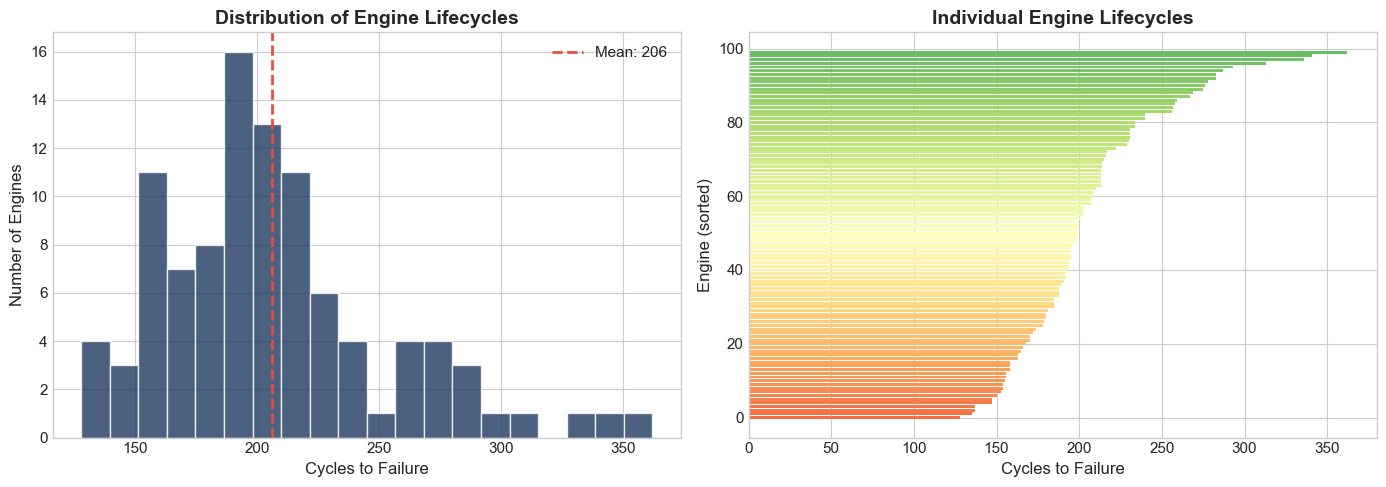

In [43]:
# Visualize engine lifecycles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of engine lifecycles
axes[0].hist(engine_cycles['Total_Cycles'], bins=20, color=COLORS['primary'], 
             edgecolor='white', alpha=0.8)
axes[0].axvline(engine_cycles['Total_Cycles'].mean(), color=COLORS['danger'], 
                linestyle='--', linewidth=2, label=f"Mean: {engine_cycles['Total_Cycles'].mean():.0f}")
axes[0].set_xlabel('Cycles to Failure', fontsize=12)
axes[0].set_ylabel('Number of Engines', fontsize=12)
axes[0].set_title('Distribution of Engine Lifecycles', fontsize=14, fontweight='bold')
axes[0].legend()

# Bar chart of individual engine lifecycles
sorted_cycles = engine_cycles.sort_values('Total_Cycles')
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(sorted_cycles)))
axes[1].barh(range(len(sorted_cycles)), sorted_cycles['Total_Cycles'], color=colors)
axes[1].set_xlabel('Cycles to Failure', fontsize=12)
axes[1].set_ylabel('Engine (sorted)', fontsize=12)
axes[1].set_title('Individual Engine Lifecycles', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## 6. Compute RUL for Training Data

For the training data, we need to calculate RUL for each time step:
$$RUL(t) = t_{failure} - t_{current}$$


In [44]:
def compute_rul(df):
    """Compute RUL for each row in the training data."""
    # Get maximum cycle for each engine (failure point)
    max_cycles = df.groupby('unit_number')['time_cycles'].max()
    
    # Compute RUL
    df = df.copy()
    df['RUL'] = df.apply(
        lambda row: max_cycles[row['unit_number']] - row['time_cycles'], 
        axis=1
    )
    return df

train_df = compute_rul(train_df)
print("RUL computed for training data!")
print(f"\nRUL range: {train_df['RUL'].min()} to {train_df['RUL'].max()}")
train_df[['unit_number', 'time_cycles', 'RUL']].head(10)


RUL computed for training data!

RUL range: 0.0 to 361.0


,unit_number,time_cycles,RUL
0,1,1,191.0
1,1,2,190.0
2,1,3,189.0
3,1,4,188.0
4,1,5,187.0
5,1,6,186.0
6,1,7,185.0
7,1,8,184.0
8,1,9,183.0
9,1,10,182.0


## 7. Operational Settings Analysis


In [45]:
# Analyze operational settings
print("Unique values in operational settings (FD001 - Single operating condition):")
for col in operational_settings:
    unique_vals = train_df[col].nunique()
    print(f"  {col}: {unique_vals} unique values")
    if unique_vals <= 10:
        print(f"    Values: {sorted(train_df[col].unique())}")


Unique values in operational settings (FD001 - Single operating condition):
  op_setting_1: 158 unique values
  op_setting_2: 13 unique values
  op_setting_3: 1 unique values
    Values: [np.float64(100.0)]


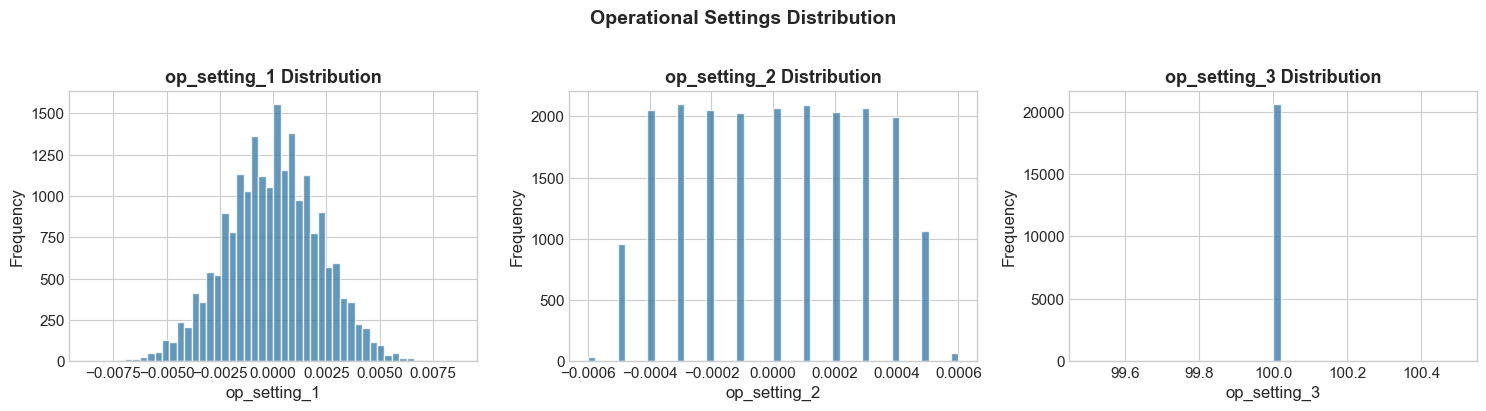

In [46]:
# Visualize operational settings
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(operational_settings):
    axes[i].hist(train_df[col], bins=50, color=COLORS['secondary'], edgecolor='white', alpha=0.8)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].set_title(f'{col} Distribution', fontsize=13, fontweight='bold')

plt.suptitle('Operational Settings Distribution', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [47]:
# Check for constant sensors (no variation)
print("Sensor Variability Analysis:")
print("=" * 50)

sensor_stats = []
for sensor in sensor_columns:
    std = train_df[sensor].std()
    cv = (std / train_df[sensor].mean() * 100) if train_df[sensor].mean() != 0 else 0
    sensor_stats.append({
        'Sensor': sensor,
        'Mean': train_df[sensor].mean(),
        'Std': std,
        'CV%': cv,
        'Min': train_df[sensor].min(),
        'Max': train_df[sensor].max()
    })

sensor_df = pd.DataFrame(sensor_stats)
sensor_df = sensor_df.sort_values('CV%', ascending=False)

# Identify low-variance sensors
low_var_sensors = sensor_df[sensor_df['CV%'] < 0.1]['Sensor'].tolist()
print(f"\n⚠️ Low variance sensors (CV < 0.1%): {low_var_sensors}")
print("   These sensors may not be useful for prediction.\n")

sensor_df


Sensor Variability Analysis:

⚠️ Low variance sensors (CV < 0.1%): ['T24', 'P2', 'NRf', 'P30', 'T50', 'farB', 'T2', 'Nc', 'PCNfR_dmd', 'Nf_dmd']
   These sensors may not be useful for prediction.



,Sensor,Mean,Std,CV%,Min,Max
3,T48,1408.933782,9.000605e+00,6.388238e-01,1382.2500,1441.4900
10,Ps30,47.541168,2.670874e-01,5.618023e-01,46.8500,48.5300
19,W31,38.816271,1.807464e-01,4.656460e-01,38.1400,39.4300
20,W32,23.289705,1.082509e-01,4.648014e-01,22.8942,23.6184
14,BPR,8.442146,3.750504e-02,4.442595e-01,8.3249,8.5848
16,htBleed,393.210654,1.548763e+00,3.938762e-01,388.0000,400.0000
2,T30,1590.523119,6.131150e+00,3.854801e-01,1571.0400,1616.9100
8,Nf,9065.242941,2.208288e+01,2.435994e-01,9021.7300,9244.5900
13,NRc,8143.752722,1.907618e+01,2.342431e-01,8099.9400,8293.7200
6,P15,553.367711,8.850923e-01,1.599465e-01,549.8500,556.0600


## 9. Sensor Time Series Visualization

Let's visualize how sensors degrade over time for a few engines.


In [48]:
# Select key sensors for visualization (high variance sensors)
#key_sensors = ['T24', 'T30', 'T48', 'P30', 'Nf', 'Nc', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']

# Remove low variance sensors from key sensors
useful_sensors = [s for s in sensor_columns if s not in low_var_sensors]
print(f"Useful sensors for analysis: {useful_sensors}")


Useful sensors for analysis: ['T30', 'T48', 'P15', 'Nf', 'Ps30', 'phi', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']


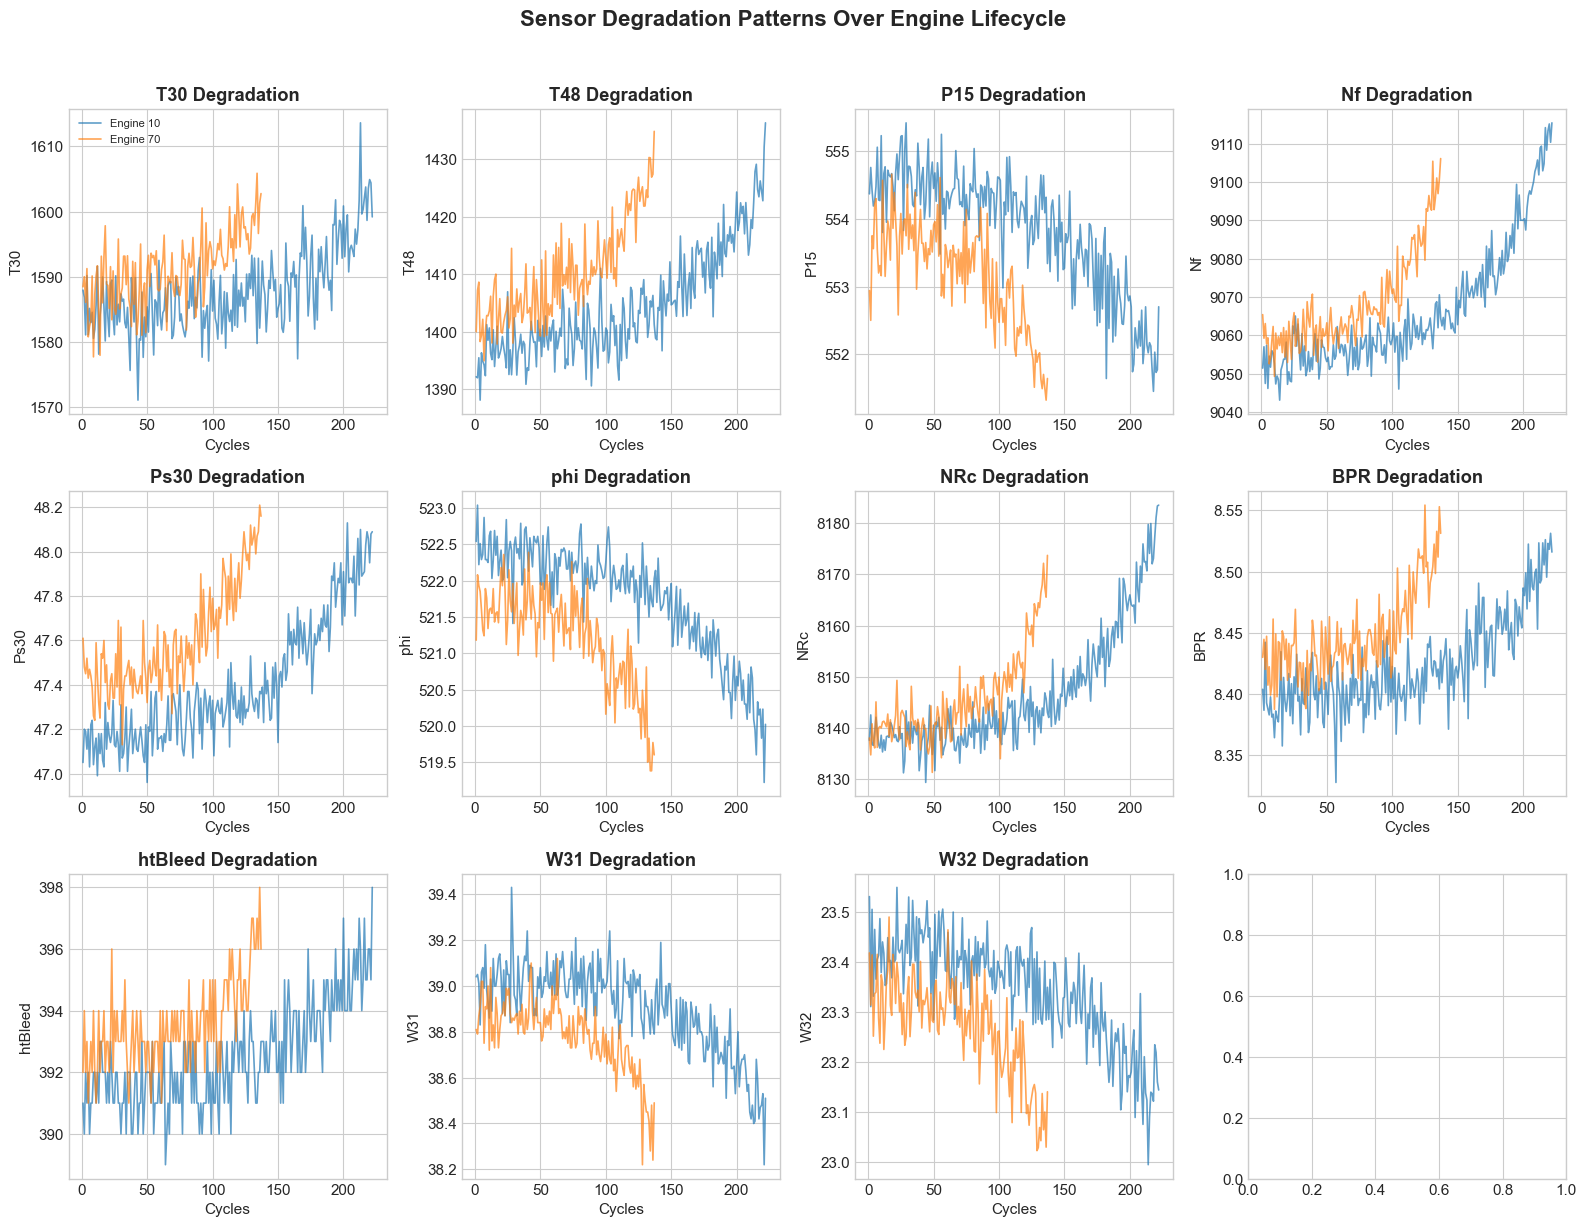

In [52]:
# Plot sensor degradation for multiple engines
sample_engines = [10, 70]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

sensors_to_plot = useful_sensors[:12]  # Plot first 12 useful sensors

for idx, sensor in enumerate(sensors_to_plot):
    ax = axes[idx]
    for engine in sample_engines:
        engine_data = train_df[train_df['unit_number'] == engine]
        ax.plot(engine_data['time_cycles'], engine_data[sensor], 
                alpha=0.7, linewidth=1.2, label=f'Engine {engine}')
        
    #set x and y limits
    #ax.set_xlim(0, engine_data['time_cycles'].max())
    #ax.set_ylim(engine_data[sensor].min()*0.5, engine_data[sensor].max()*1.5)
    
    ax.set_xlabel('Cycles')
    ax.set_ylabel(sensor)
    ax.set_title(f'{sensor} Degradation', fontweight='bold')
    
    if idx == 0:
        ax.legend(fontsize=8, loc='best')

plt.suptitle('Sensor Degradation Patterns Over Engine Lifecycle', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 10. Degradation Pattern: Single Engine Deep Dive


In [53]:
# Select one engine for detailed analysis
engine_id = 1
engine_data = train_df[train_df['unit_number'] == engine_id]

print(f"Engine {engine_id} Analysis:")
print(f"  Total cycles: {len(engine_data)}")
print(f"  Time to failure: {engine_data['time_cycles'].max()} cycles")


Engine 1 Analysis:
  Total cycles: 192
  Time to failure: 192 cycles


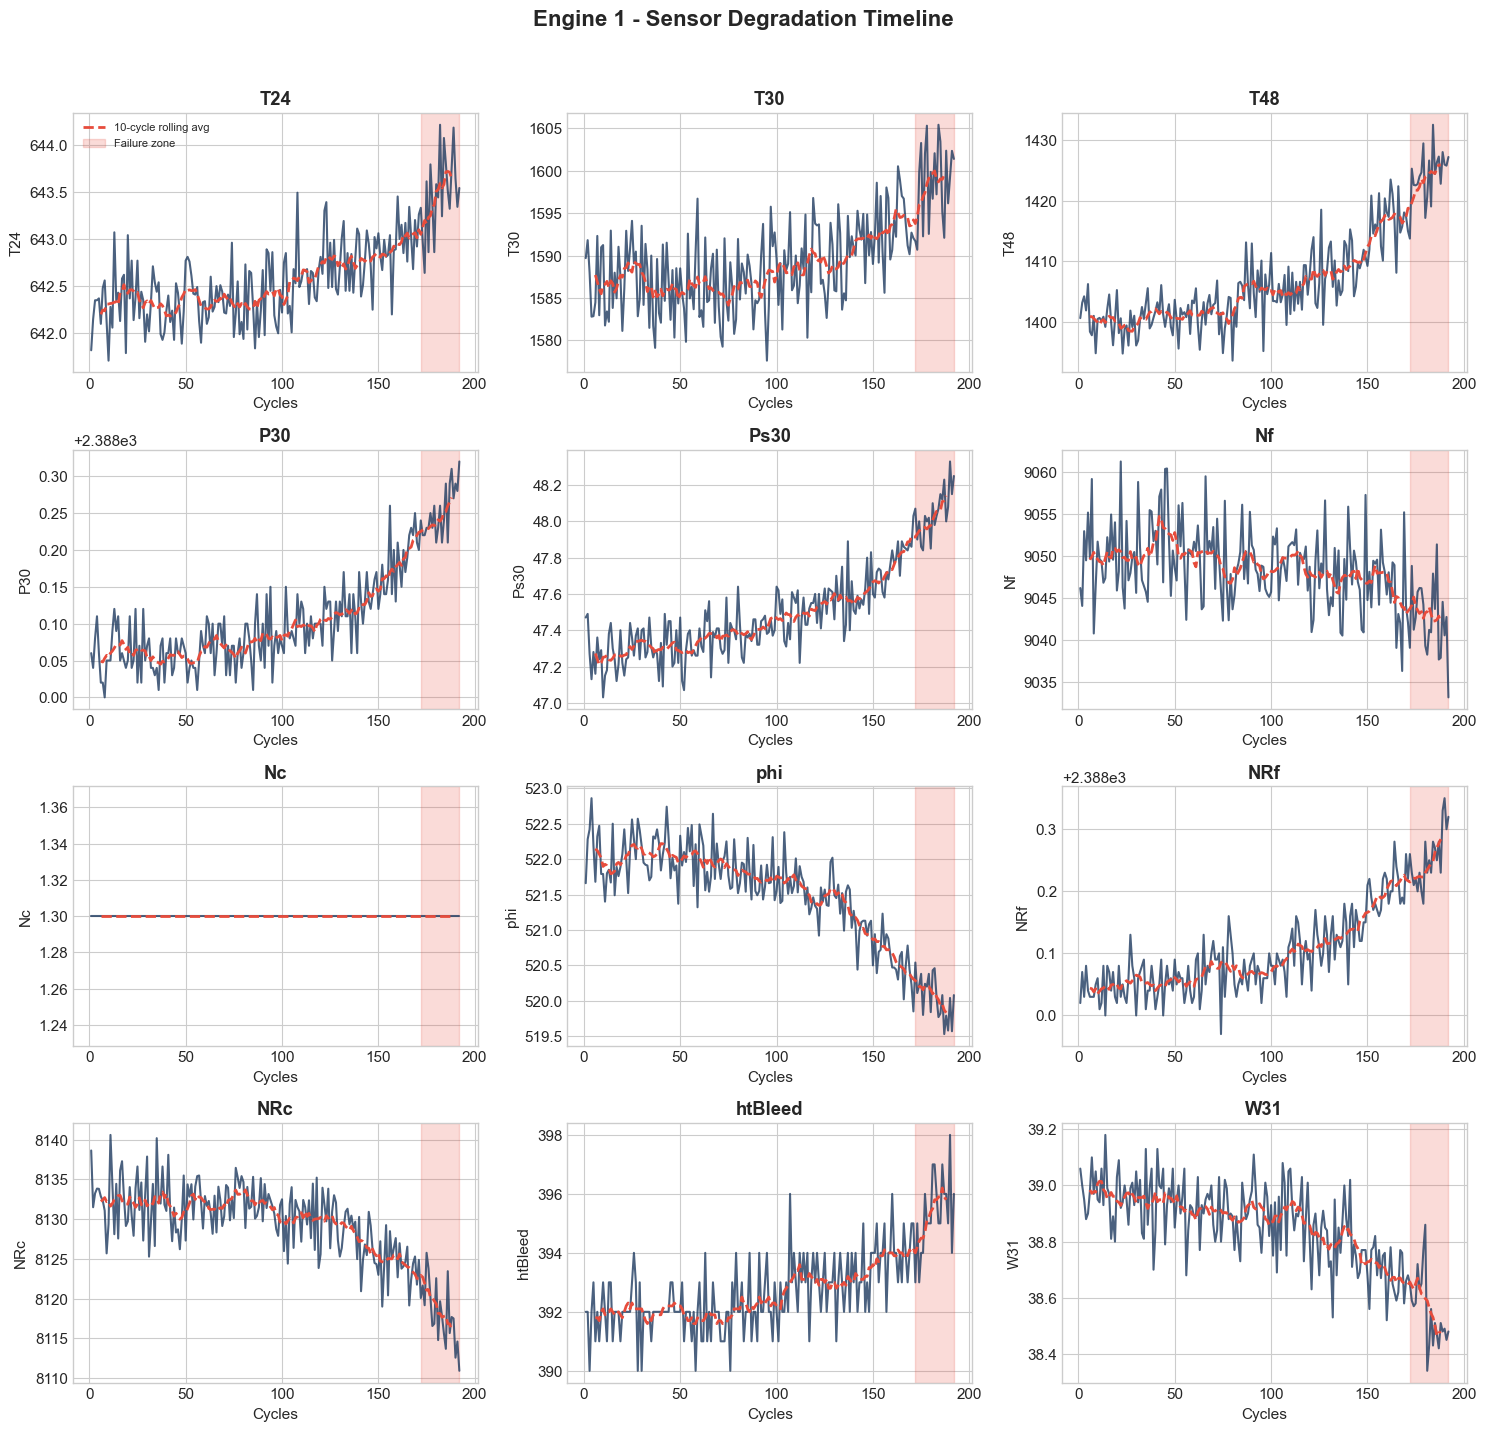

In [54]:
# Detailed sensor plot for one engine
fig, axes = plt.subplots(4, 3, figsize=(15, 14))
axes = axes.flatten()

critical_sensors = ['T24', 'T30', 'T48', 'P30', 'Ps30', 'Nf', 'Nc', 'phi', 'NRf', 'NRc', 'htBleed', 'W31']

for idx, sensor in enumerate(critical_sensors):
    ax = axes[idx]
    
    # Plot sensor values
    ax.plot(engine_data['time_cycles'], engine_data[sensor], 
            color=COLORS['primary'], linewidth=1.5, alpha=0.8)
    
    # Add rolling average
    rolling_mean = engine_data[sensor].rolling(window=10, center=True).mean()
    ax.plot(engine_data['time_cycles'], rolling_mean, 
            color=COLORS['danger'], linewidth=2, linestyle='--', label='10-cycle rolling avg')
    
    # Mark failure zone (last 20 cycles)
    failure_zone_start = engine_data['time_cycles'].max() - 20
    ax.axvspan(failure_zone_start, engine_data['time_cycles'].max(), 
               alpha=0.2, color=COLORS['danger'], label='Failure zone')
    
    ax.set_xlabel('Cycles')
    ax.set_ylabel(sensor)
    ax.set_title(f'{sensor}', fontweight='bold')
    
    if idx == 0:
        ax.legend(fontsize=8)

plt.suptitle(f'Engine {engine_id} - Sensor Degradation Timeline', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 11. Correlation Analysis


In [55]:
# Correlation with RUL
rul_correlations = train_df[sensor_columns + ['RUL']].corr()['RUL'].drop('RUL').sort_values()

print("Sensor Correlation with RUL:")
print("=" * 50)
print(rul_correlations)


Sensor Correlation with RUL:
Ps30        -0.696228
T48         -0.678948
BPR         -0.642667
T24         -0.606484
htBleed     -0.606154
T30         -0.584520
P30         -0.563968
NRf         -0.562569
Nf          -0.390102
NRc         -0.306769
P2          -0.128348
W31          0.629428
W32          0.635662
P15          0.657223
phi          0.671983
T2                NaN
T50               NaN
Nc                NaN
farB              NaN
Nf_dmd            NaN
PCNfR_dmd         NaN
Name: RUL, dtype: float64


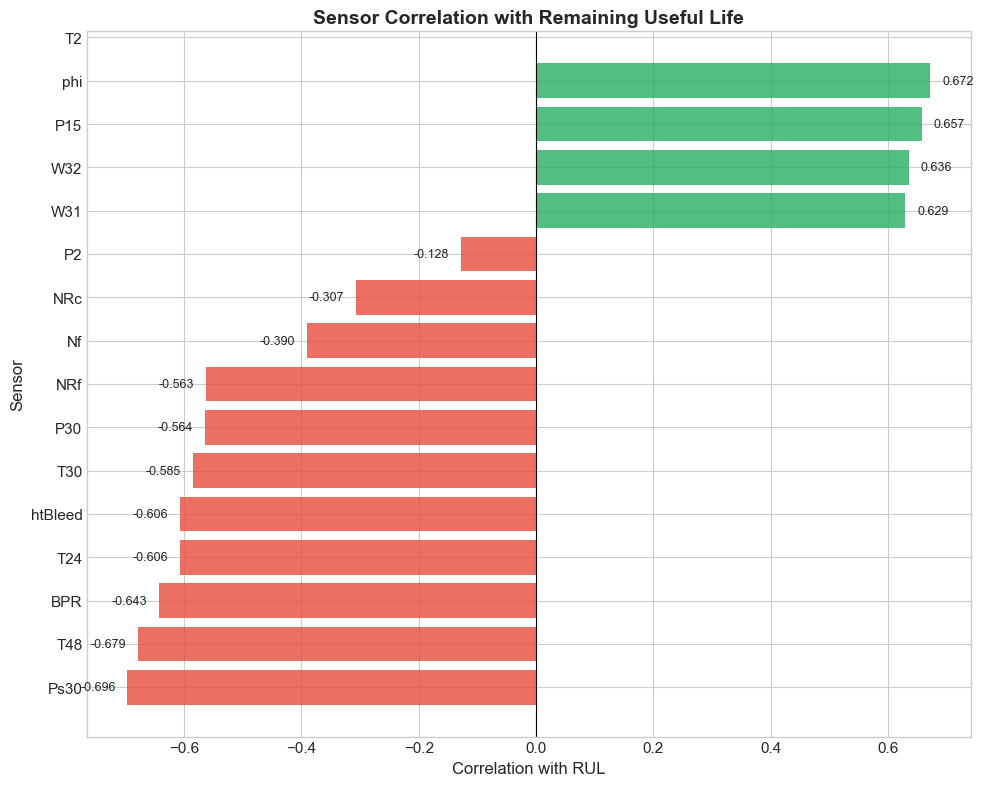

In [56]:
# Visualize RUL correlations
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#E74C3C' if x < 0 else '#27AE60' for x in rul_correlations]
bars = ax.barh(rul_correlations.index, rul_correlations.values, color=colors, alpha=0.8)

ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Correlation with RUL', fontsize=12)
ax.set_ylabel('Sensor', fontsize=12)
ax.set_title('Sensor Correlation with Remaining Useful Life', fontsize=14, fontweight='bold')

# Add value labels
for i, (sensor, corr) in enumerate(rul_correlations.items()):
    ax.text(corr + 0.02 if corr >= 0 else corr - 0.02, i, f'{corr:.3f}', 
            va='center', ha='left' if corr >= 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()


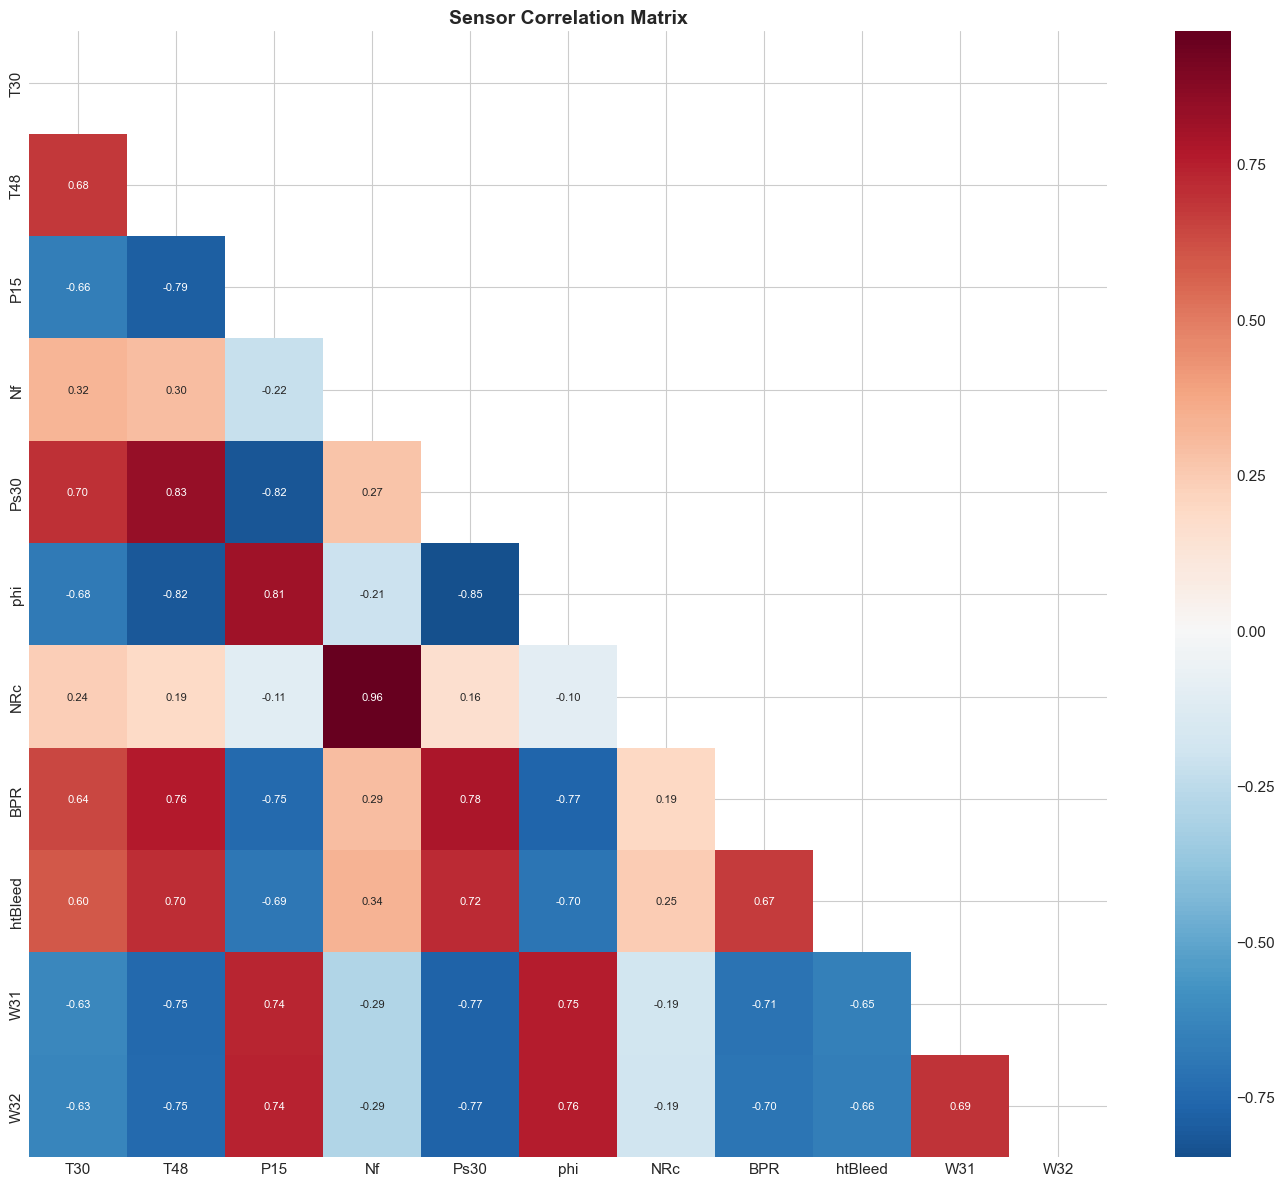

In [57]:
# Sensor correlation heatmap
# Select sensors with meaningful variation
useful_sensor_cols = [s for s in sensor_columns if s not in low_var_sensors]

fig, ax = plt.subplots(figsize=(14, 12))
corr_matrix = train_df[useful_sensor_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, annot_kws={'size': 8})

ax.set_title('Sensor Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 13. Degradation Trajectory Visualization

Visualize how key sensors change as RUL decreases (approaching failure).


In [58]:
# Top correlated sensors with RUL
top_sensors = rul_correlations.abs().sort_values(ascending=False).head(6).index.tolist()
print(f"Top sensors correlated with RUL: {top_sensors}")


Top sensors correlated with RUL: ['Ps30', 'T48', 'phi', 'P15', 'BPR', 'W32']


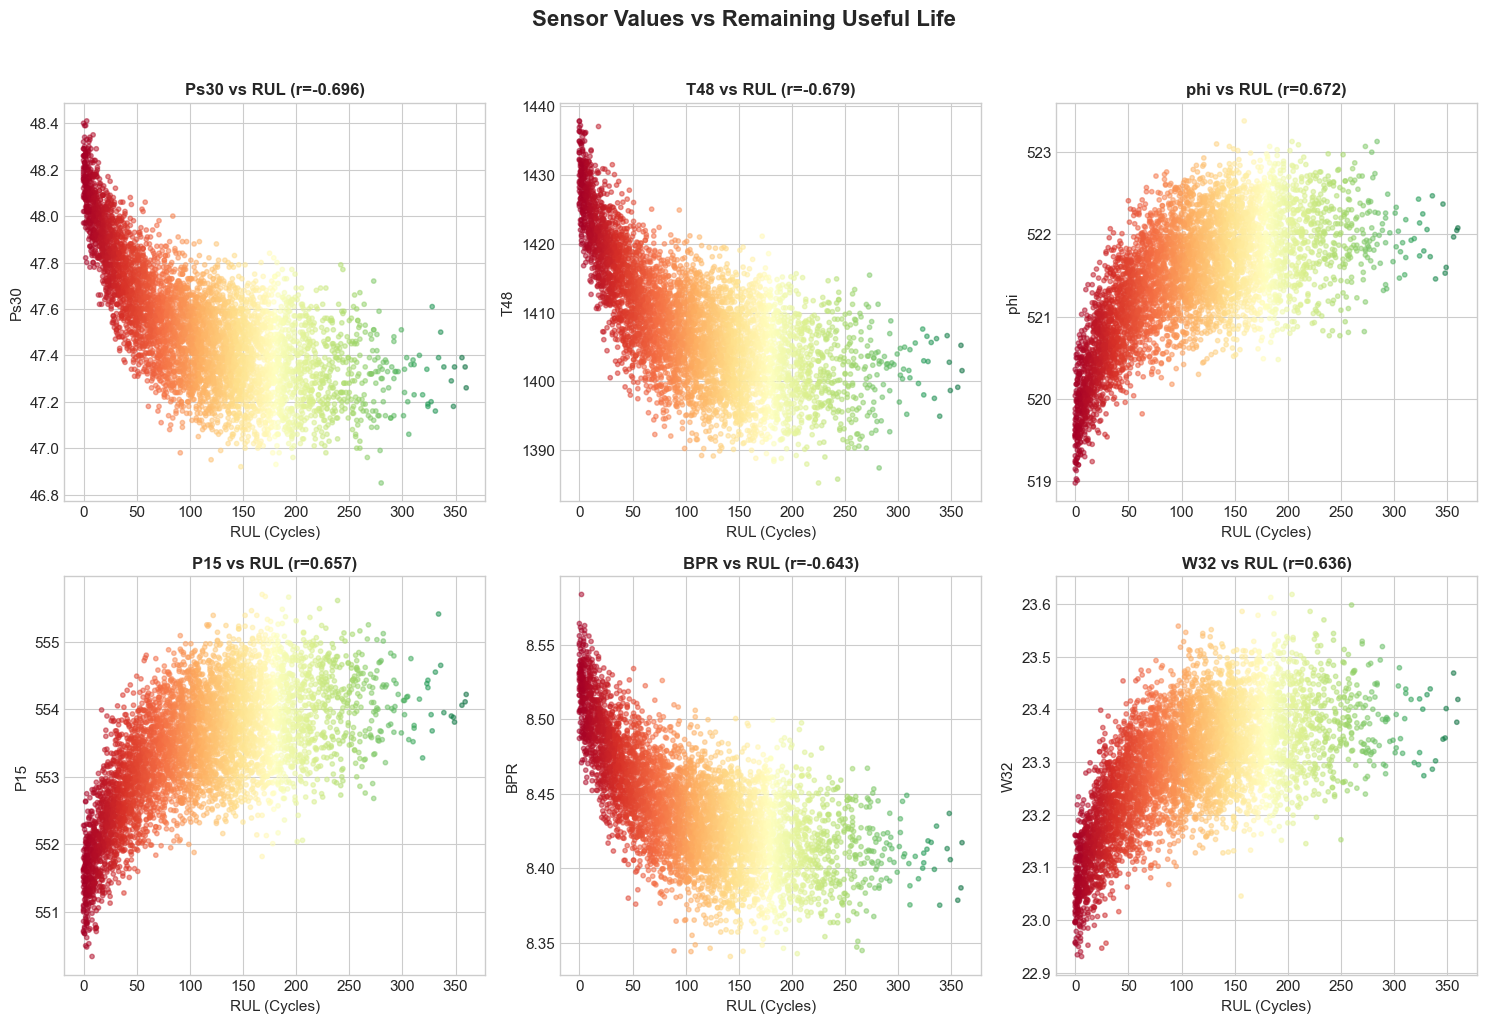

In [59]:
# Sensor vs RUL scatter plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, sensor in enumerate(top_sensors):
    ax = axes[idx]
    
    # Sample data for faster plotting
    sample = train_df.sample(n=min(5000, len(train_df)), random_state=42)
    
    scatter = ax.scatter(sample['RUL'], sample[sensor], 
                         c=sample['RUL'], cmap='RdYlGn', 
                         alpha=0.5, s=10)
    
    ax.set_xlabel('RUL (Cycles)', fontsize=11)
    ax.set_ylabel(sensor, fontsize=11)
    ax.set_title(f'{sensor} vs RUL (r={rul_correlations[sensor]:.3f})', 
                 fontsize=12, fontweight='bold')

plt.suptitle('Sensor Values vs Remaining Useful Life', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 14. Compare All Datasets


In [60]:
# Load and compare all datasets
datasets = ['FD001', 'FD002', 'FD003', 'FD004']
comparison_stats = []

for ds in datasets:
    train, test, rul = load_dataset(ds)
    train = compute_rul(train)
    
    stats = {
        'Dataset': ds,
        'Train Engines': train['unit_number'].nunique(),
        'Test Engines': test['unit_number'].nunique(),
        'Train Rows': len(train),
        'Test Rows': len(test),
        'Avg Cycles': train.groupby('unit_number')['time_cycles'].max().mean(),
        'Op Settings Unique': train[operational_settings].drop_duplicates().shape[0],
        'Mean Test RUL': rul['RUL'].mean()
    }
    comparison_stats.append(stats)

comparison_df = pd.DataFrame(comparison_stats)
comparison_df


,Dataset,Train Engines,Test Engines,Train Rows,Test Rows,Avg Cycles,Op Settings Unique,Mean Test RUL
0,FD001,100,100,20631,13096,206.310000,1423,75.520000
1,FD002,260,259,53759,33991,206.765385,9824,81.185328
2,FD003,100,100,24720,16596,247.200000,1479,75.320000
3,FD004,249,248,61249,41214,245.979920,10232,86.552419


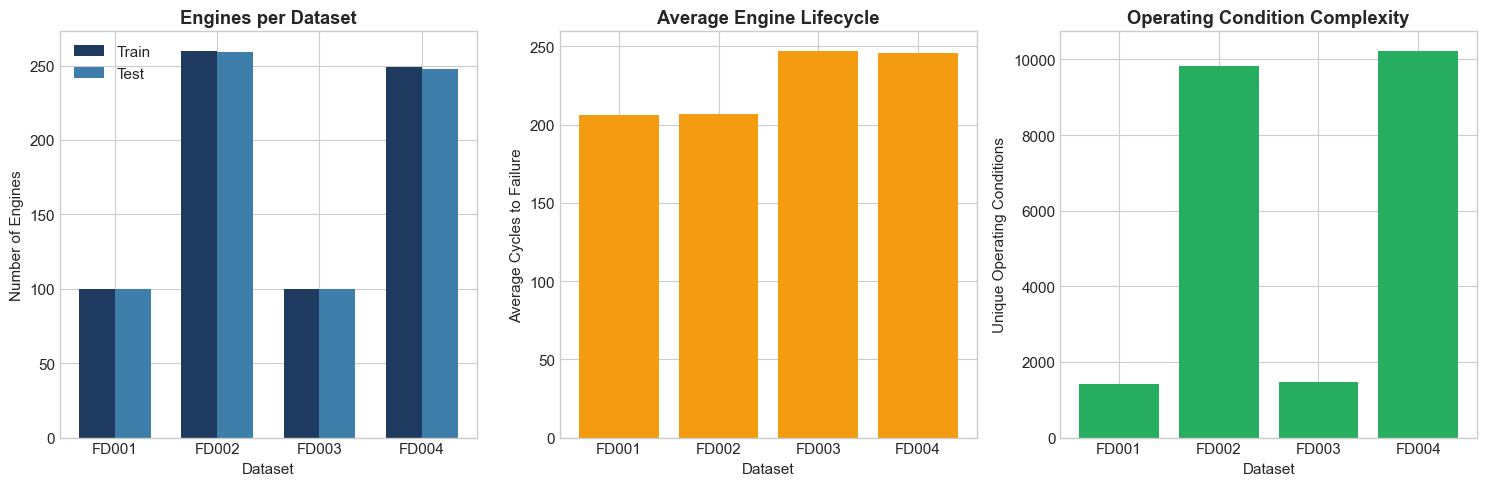

In [61]:
# Visualize dataset comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Number of engines
x = np.arange(len(datasets))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Train Engines'], width, label='Train', color=COLORS['primary'])
axes[0].bar(x + width/2, comparison_df['Test Engines'], width, label='Test', color=COLORS['secondary'])
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Number of Engines')
axes[0].set_title('Engines per Dataset', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].legend()

# Average cycles
axes[1].bar(datasets, comparison_df['Avg Cycles'], color=COLORS['accent'])
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Average Cycles to Failure')
axes[1].set_title('Average Engine Lifecycle', fontweight='bold')

# Operating conditions
axes[2].bar(datasets, comparison_df['Op Settings Unique'], color=COLORS['success'])
axes[2].set_xlabel('Dataset')
axes[2].set_ylabel('Unique Operating Conditions')
axes[2].set_title('Operating Condition Complexity', fontweight='bold')

plt.tight_layout()
plt.show()


## 15. Key Findings Summary


In [62]:
print("="*80)
print("📊 DATA EXPLORATION - KEY FINDINGS")
print("="*80)

print("\n1️⃣ DATASET CHARACTERISTICS (FD001)")
print(f"   • Training engines: {train_df['unit_number'].nunique()}")
print(f"   • Total training samples: {len(train_df):,}")
print(f"   • Average lifecycle: {engine_cycles['Total_Cycles'].mean():.0f} cycles")
print(f"   • Lifecycle range: {engine_cycles['Total_Cycles'].min()} - {engine_cycles['Total_Cycles'].max()} cycles")

print("\n2️⃣ SENSOR ANALYSIS")
print(f"   • Total sensors: {len(sensor_columns)}")
print(f"   • Low variance sensors (to drop): {low_var_sensors}")
print(f"   • Useful sensors: {len(sensor_columns) - len(low_var_sensors)}")

print("\n3️⃣ TOP SENSORS CORRELATED WITH RUL")
for sensor in top_sensors[:5]:
    print(f"   • {sensor}: r = {rul_correlations[sensor]:.4f}")

print("\n4️⃣ DEGRADATION PATTERNS")
print("   • Sensors show gradual degradation over time")
print("   • Degradation accelerates near end-of-life")
print("   • Multiple sensors are highly correlated (redundancy)")

print("\n5️⃣ RECOMMENDATIONS FOR MODELING")
print("   • Remove constant/low-variance sensors")
print("   • Normalize sensor data per engine")
print("   • Consider rolling statistics as features")
print("   • Cap RUL at ~125 cycles (piecewise linear)")
print("   • Use asymmetric loss function for training")

print("\n" + "="*80)


📊 DATA EXPLORATION - KEY FINDINGS

1️⃣ DATASET CHARACTERISTICS (FD001)
   • Training engines: 100
   • Total training samples: 20,631
   • Average lifecycle: 206 cycles
   • Lifecycle range: 128 - 362 cycles

2️⃣ SENSOR ANALYSIS
   • Total sensors: 21
   • Low variance sensors (to drop): ['T24', 'P2', 'NRf', 'P30', 'T50', 'farB', 'T2', 'Nc', 'PCNfR_dmd', 'Nf_dmd']
   • Useful sensors: 11

3️⃣ TOP SENSORS CORRELATED WITH RUL
   • Ps30: r = -0.6962
   • T48: r = -0.6789
   • phi: r = 0.6720
   • P15: r = 0.6572
   • BPR: r = -0.6427

4️⃣ DEGRADATION PATTERNS
   • Sensors show gradual degradation over time
   • Degradation accelerates near end-of-life
   • Multiple sensors are highly correlated (redundancy)

5️⃣ RECOMMENDATIONS FOR MODELING
   • Remove constant/low-variance sensors
   • Normalize sensor data per engine
   • Consider rolling statistics as features
   • Cap RUL at ~125 cycles (piecewise linear)
   • Use asymmetric loss function for training



---
## 📌 Next Steps

Proceed to **`02_rul_prediction_model.ipynb`** for building ML/DL models to predict Remaining Useful Life.

---


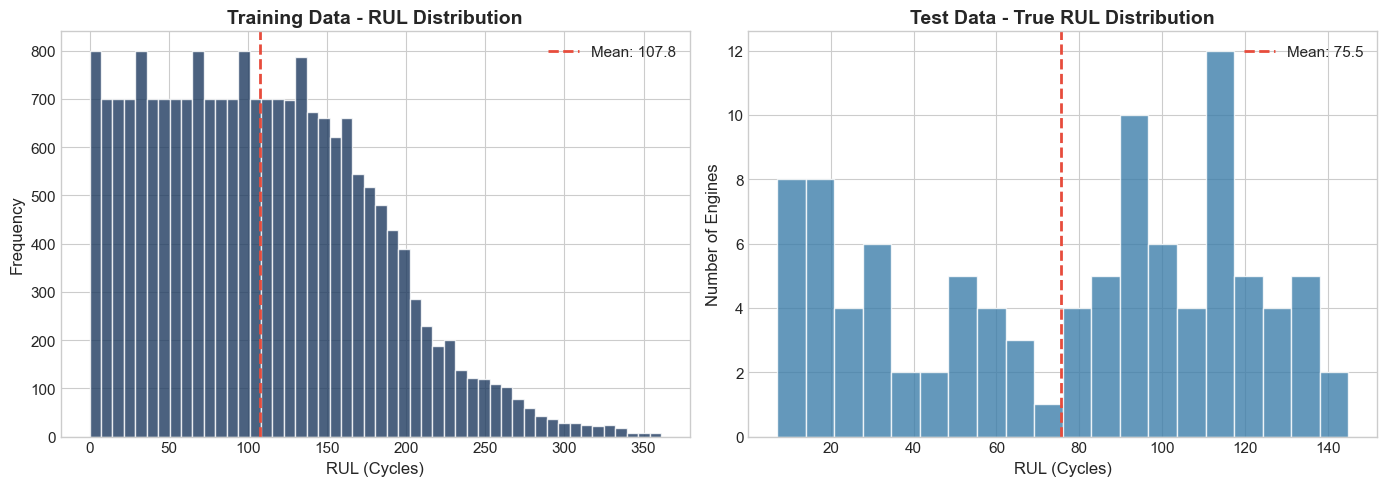

In [63]:
# Test set RUL distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training RUL distribution
axes[0].hist(train_df['RUL'], bins=50, color=COLORS['primary'], edgecolor='white', alpha=0.8)
axes[0].axvline(train_df['RUL'].mean(), color=COLORS['danger'], linestyle='--', 
                linewidth=2, label=f"Mean: {train_df['RUL'].mean():.1f}")
axes[0].set_xlabel('RUL (Cycles)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Training Data - RUL Distribution', fontsize=14, fontweight='bold')
axes[0].legend()

# Test set true RUL distribution
axes[1].hist(rul_df['RUL'], bins=20, color=COLORS['secondary'], edgecolor='white', alpha=0.8)
axes[1].axvline(rul_df['RUL'].mean(), color=COLORS['danger'], linestyle='--', 
                linewidth=2, label=f"Mean: {rul_df['RUL'].mean():.1f}")
axes[1].set_xlabel('RUL (Cycles)', fontsize=12)
axes[1].set_ylabel('Number of Engines', fontsize=12)
axes[1].set_title('Test Data - True RUL Distribution', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()


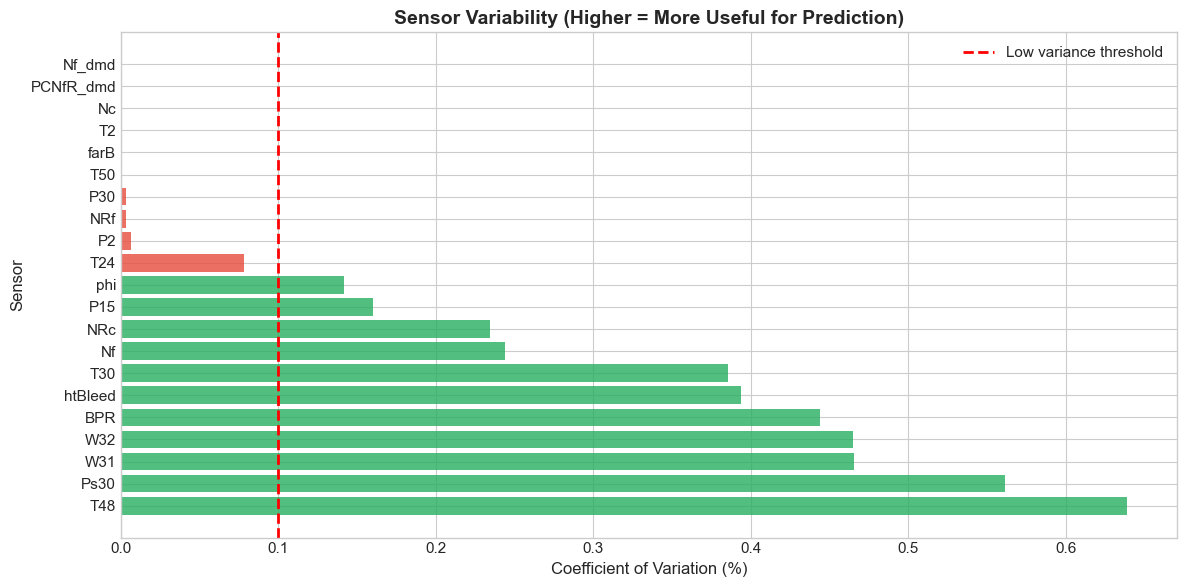

In [65]:
# Visualize sensor variability
fig, ax = plt.subplots(figsize=(12, 6))

colors = [COLORS['danger'] if cv < 0.1 else COLORS['success'] for cv in sensor_df['CV%']]
bars = ax.barh(sensor_df['Sensor'], sensor_df['CV%'], color=colors, alpha=0.8)

ax.axvline(0.1, color='red', linestyle='--', linewidth=2, label='Low variance threshold')
ax.set_xlabel('Coefficient of Variation (%)', fontsize=12)
ax.set_ylabel('Sensor', fontsize=12)
ax.set_title('Sensor Variability (Higher = More Useful for Prediction)', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()
